In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import altair as alt
import plotly.graph_objects as go

In [3]:
data = pd.read_csv('data/mbta_ridership.csv')
data = data[data['season'] == 'Fall 2019']
data.head()

,mode,season,route_id,route_name,direction_id,day_type_id,day_type_name,time_period_id,time_period_name,stop_name,stop_id,total_ons,total_offs,number_service_days,average_ons,average_offs,average_flow,ObjectId
0,0,Fall 2019,Green,Green Line,0,day_type_01,weekday,time_period_01,VERY_EARLY_MORNING,Allston Street,place-alsgr,0,17,77,0,0,4,1
1,0,Fall 2019,Green,Green Line,0,day_type_01,weekday,time_period_01,VERY_EARLY_MORNING,Arlington,place-armnl,2675,8021,77,35,104,381,2
2,0,Fall 2019,Green,Green Line,0,day_type_01,weekday,time_period_01,VERY_EARLY_MORNING,Babcock Street,place-babck,0,151,77,0,2,8,3
3,0,Fall 2019,Green,Green Line,0,day_type_01,weekday,time_period_01,VERY_EARLY_MORNING,Back of the Hill,place-bckhl,0,36,77,0,0,4,4
4,0,Fall 2019,Green,Green Line,0,day_type_01,weekday,time_period_01,VERY_EARLY_MORNING,Beaconsfield,place-bcnfd,12,67,77,0,1,44,5


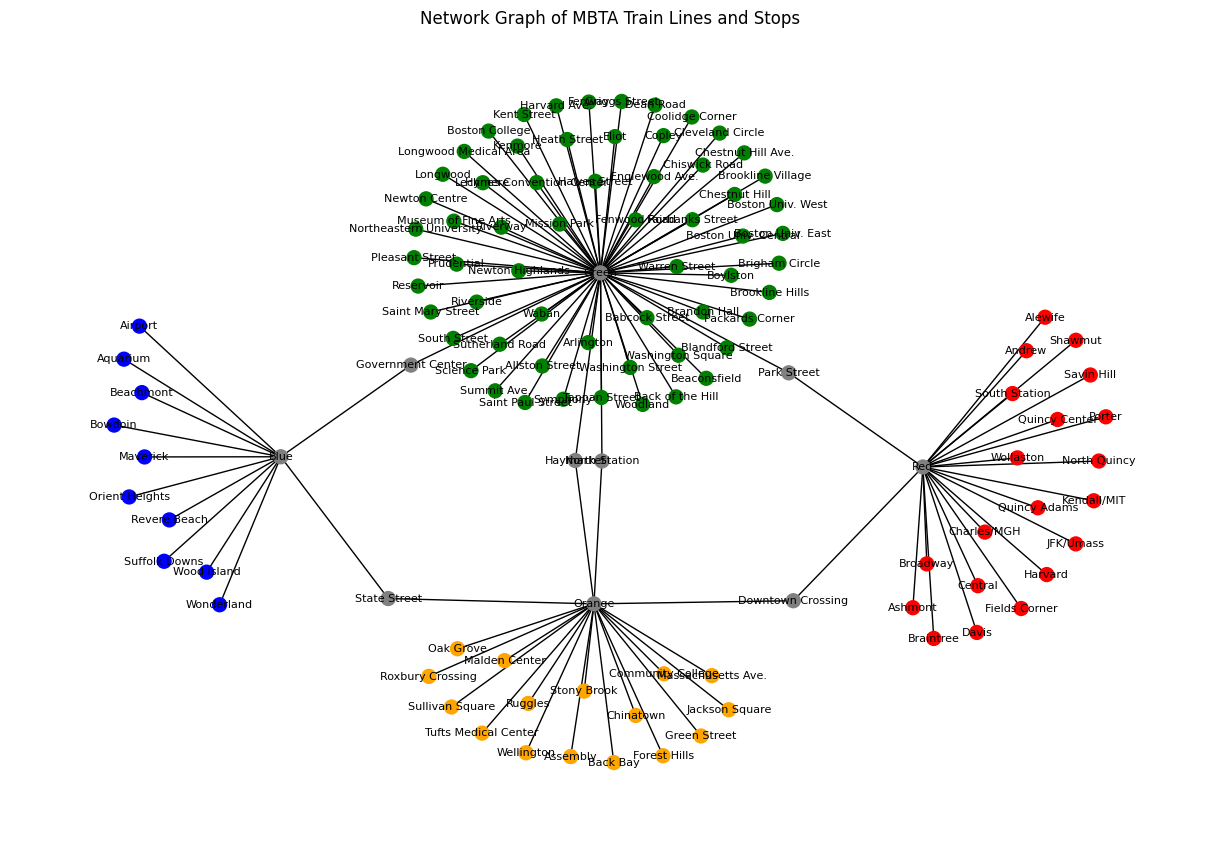

In [30]:
stops = data['stop_name'].unique()
lines = data['route_id'].unique()
average_flow = data['average_flow']

G = nx.Graph()

for idx, row in data.iterrows():
    G.add_edge(row['route_id'], row['stop_name'])

plt.figure(figsize=(12, 8))

route_colors = {
    'Green': 'green',
    'Blue': 'blue',
    'Orange': 'orange',
    'Red': 'red'
}

node_colors = []
for stop in G.nodes():
    routes = data[data['stop_name'] == stop]['route_id'].unique()
    if len(routes) == 1:
        route_id = routes[0]
        color = route_colors.get(route_id, 'gray')
        node_colors.append(color)
    else:
        node_colors.append('gray')

pos = nx.kamada_kawai_layout(G)

nx.draw(G, pos, with_labels=True, node_size=100, node_color=node_colors, font_size=8)

plt.title("Network Graph of MBTA Train Lines and Stops")
# plt.savefig('images/network_graph.png')
plt.show()

In [37]:
time_period_order = [
    'VERY_EARLY_MORNING',
    'EARLY_AM',
    'AM_PEAK',
    'MIDDAY_BASE',
    'MIDDAY_SCHOOL',
    'PM_PEAK',
    'OFF_PEAK',
    'EVENING',
    'LATE_EVENING',
    'NIGHT'
]

# alt.data_transformers.enable('json')

radio = alt.binding_radio(options=list(data['route_name'].unique()))
radio_selection = alt.selection_single(fields=['route_name'], bind=radio, name='Select Line')

# Create the horizontal bar chart for total_ons
bar_chart_ons = alt.Chart(data).mark_bar().encode(
    x='sum(total_ons)',
    y=alt.Y('time_period_name', sort=time_period_order),
    # color=alt.condition(
    #     (alt.datum.route_name == 'Green Line') & (alt.datum.route_name == radio_selection['route_name']),
    #     alt.ColorValue('green'),
    #     alt.value('lightgray')
    # ),
    tooltip=['route_name', 'time_period_name', 'sum(total_ons)'],
    opacity=alt.condition(radio_selection, alt.value(1), alt.value(0.2))
).add_selection(
    radio_selection
).transform_filter(
    radio_selection
)

# Create the horizontal bar chart for total_offs
bar_chart_offs = alt.Chart(data).mark_bar().encode(
    x='sum(total_offs)',
    y=alt.Y('time_period_name', sort=time_period_order),
    # color=alt.condition(
    #     (alt.datum.route_name == 'Green Line') & (alt.datum.route_name == radio_selection['route_name']),
    #     alt.ColorValue('green'),
    #     alt.value('lightgray')
    # ),
    tooltip=['route_name', 'time_period_name', 'sum(total_offs)'],
    opacity=alt.condition(radio_selection, alt.value(1), alt.value(0.2))
).add_selection(
    radio_selection
).transform_filter(
    radio_selection
)

bar_chart_ons | bar_chart_offs

c:\Users\ibaba\AppData\Local\Programs\Python\Python312\Lib\site-packages\altair\utils\deprecation.py:65: AltairDeprecationWarning: 'selection_single' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
c:\Users\ibaba\AppData\Local\Programs\Python\Python312\Lib\site-packages\altair\utils\deprecation.py:65: AltairDeprecationWarning: 'add_selection' is deprecated. Use 'add_params' instead.
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)


alt.HConcatChart(...)

In [31]:
df_grouped = data.groupby(['stop_name', 'route_name']).agg({'average_flow': 'mean'}).reset_index() 
color_scale = alt.Scale(domain=df_grouped['route_name'].unique().tolist(), range=['#1f77b4', '#d62728', '#2ca02c','#ff7f0e'])
bubble_chart = alt.Chart(df_grouped).mark_circle().encode( x=alt.X('stop_name:N', axis=None), y=alt.Y('average_flow:Q', axis=None), size=alt.Size('average_flow:Q', scale=alt.Scale(range=[50, 1000]), title='Average Flow'), color=alt.Color('route_name:N', title='Line', scale=color_scale), tooltip=['stop_name:N', 'route_name:N', 'average_flow:Q'] ).properties( width=800, height=400 ) 
bubble_chart

alt.Chart(...)